In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import io
from contextlib import redirect_stdout

In [3]:
def load_data(file_path):
    df = pd.read_excel(file_path)
    print(f"Dataset loaded with shape: {df.shape}")
    return df

In [4]:
def initial_exploration(df):
    print("\nBasic Information:")
    print(df.info())

    print("\nFirst 5 rows:")
    print(df.head())

    print("\nSummary Statistics:")
    print(df.describe())

    print("\nUnique Values Count:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")

    return df

In [5]:
def assess_completeness(df):
    print("\nDATA COMPLETENESS ASSESSMENT")
    # Calculate missing values
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100

    # Create a summary DataFrame
    missing_summary = pd.DataFrame({
        'Missing Values': missing_values,
        'Missing Percentage': missing_percent.round(2)
    })

    print("\nMissing Values Summary:")
    print(missing_summary)

    # Visualize missing values if any exist
    if missing_values.sum() > 0:
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.isnull(), cmap='viridis', yticklabels=False, cbar=False)
        plt.title('Missing Values Heatmap')
        plt.tight_layout()
        plt.show()

        # Identify patterns in missing data
        print("\nPatterns in Missing Data:")
        columns_with_missing = missing_values[missing_values > 0].index.tolist()
        if columns_with_missing:
            for col in columns_with_missing:
                print(f"\nMissing values in {col}:")
                # Check if missing values are associated with specific categories
                for other_col in df.select_dtypes(include=['object', 'category']).columns:
                    if other_col != col:
                        cross_tab = pd.crosstab(df[other_col], df[col].isnull(),
                                               normalize='index', margins=True) * 100
                        if (cross_tab[True] != cross_tab.loc['All', True]).any():
                            print(f"- Relationship with {other_col}:")
                            print(cross_tab.round(2))

    return missing_summary

In [6]:
def assess_accuracy(df):
    print("\nDATA ACCURACY ASSESSMENT")

    accuracy_issues = []

    # date format and values
    if 'transaction_date' in df.columns:
        # Convert to datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(df['transaction_date']):
            try:
                # Try to convert to check validity
                pd.to_datetime(df['transaction_date'])
            except Exception as e:
                accuracy_issues.append(f"Invalid date formats detected: {str(e)}")

        # Check for future dates
        if pd.api.types.is_datetime64_any_dtype(df['transaction_date']):
            future_dates = df[df['transaction_date'] > datetime.now()]
            if not future_dates.empty:
                accuracy_issues.append(f"Found {len(future_dates)} transactions with future dates")

    # time format and values
    if 'transaction_time' in df.columns:
        if not pd.api.types.is_datetime64_any_dtype(df['transaction_time']):
            try:
                # Try to convert to check validity
                pd.to_datetime(df['transaction_time'], format='%H:%M:%S').dt.time
            except Exception as e:
                accuracy_issues.append(f"Invalid time formats detected: {str(e)}")

    # quantity values
    if 'transaction_qty' in df.columns:
        # Check for negative or zero quantities
        invalid_qty = df[df['transaction_qty'] <= 0]
        if not invalid_qty.empty:
            accuracy_issues.append(f"Found {len(invalid_qty)} transactions with zero or negative quantities")

        # Check for unreasonably large quantities
        large_qty = df[df['transaction_qty'] > 20]
        if not large_qty.empty:
            accuracy_issues.append(f"Found {len(large_qty)} transactions with unusually large quantities (>20)")

    # price values
    if 'unit_price' in df.columns:
        # Check for negative or zero prices
        invalid_price = df[df['unit_price'] <= 0]
        if not invalid_price.empty:
            accuracy_issues.append(f"Found {len(invalid_price)} products with zero or negative prices")

        # Check for unreasonably high prices
        high_price = df[df['unit_price'] > 20]
        if not high_price.empty:
            accuracy_issues.append(f"Found {len(high_price)} products with unusually high prices (>$20)")

    if accuracy_issues:
        print("\nAccuracy Issues Found:")
        for issue in accuracy_issues:
            print(f"- {issue}")
    else:
        print("\nNo major accuracy issues detected.")

    return accuracy_issues

In [7]:
def assess_consistency(df):
    print("\nDATA CONSISTENCY ASSESSMENT")

    consistency_issues = []

    # product_id to product detail mapping consistency
    if all(col in df.columns for col in ['product_id', 'product_category', 'product_type', 'product_detail']):
        # Group by product_id and check if each has multiple mappings
        product_mappings = df.groupby('product_id').agg({
            'unit_price': 'nunique',
            'product_category': 'nunique',
            'product_type': 'nunique',
            'product_detail': 'nunique'
        })

        # Products with inconsistent mappings
        inconsistent_products = product_mappings[
            (product_mappings['unit_price'] > 1) |
            (product_mappings['product_category'] > 1) |
            (product_mappings['product_type'] > 1) |
            (product_mappings['product_detail'] > 1)
        ]

        if not inconsistent_products.empty:
            consistency_issues.append(f"Found {len(inconsistent_products)} product_ids with inconsistent mappings")
            print("\nProducts with inconsistent mappings:")
            print(inconsistent_products.head(10))

            # Detailed look at some inconsistent products
            for product_id in inconsistent_products.index[:5]:
                print(f"\nDetailed view of inconsistent product_id: {product_id}")
                print(df[df['product_id'] == product_id][['product_id', 'unit_price', 'product_category', 'product_type', 'product_detail']].drop_duplicates())

    # store_id to store_location mapping consistency
    if all(col in df.columns for col in ['store_id', 'store_location']):
        # Group by store_id and check if each has multiple locations
        store_mappings = df.groupby('store_id')['store_location'].nunique()
        inconsistent_stores = store_mappings[store_mappings > 1]

        if not inconsistent_stores.empty:
            consistency_issues.append(f"Found {len(inconsistent_stores)} store_ids with multiple locations")
            print("\nStores with inconsistent locations:")
            for store_id in inconsistent_stores.index:
                print(f"Store ID {store_id} has multiple locations: {df[df['store_id'] == store_id]['store_location'].unique()}")

    # for duplicated transaction_id
    if 'transaction_id' in df.columns:
        duplicate_transactions = df[df.duplicated('transaction_id', keep=False)]
        if not duplicate_transactions.empty:
            consistency_issues.append(f"Found {len(duplicate_transactions)//2} duplicate transaction IDs")
            print(f"\nSample of duplicate transactions:")
            print(duplicate_transactions.head(10))

    # Print summary of consistency issues
    if not consistency_issues:
        print("\nNo major consistency issues detected.")

    return consistency_issues

In [8]:
def analyze_label_distribution(df):
    print("\n--- LABEL DISTRIBUTION ANALYSIS ---")

    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    for col in categorical_columns:
        print(f"\nDistribution of {col}:")
        value_counts = df[col].value_counts()
        print(value_counts.head(10))

        # distribution metrics
        total_values = len(df)
        unique_values = len(value_counts)
        top_value_percent = (value_counts.iloc[0] / total_values) * 100

        print(f"Total unique values: {unique_values}")
        print(f"Most common value: '{value_counts.index[0]}' ({top_value_percent:.2f}% of records)")

        # Create bar chart for top categories
        plt.figure(figsize=(10, 6))
        value_counts.head(10).plot(kind='bar')
        plt.title(f'Top 10 Values for {col}')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

    # Special analysis for product categories
    if 'product_category' in df.columns:
        print("\nDetailed Product Category Analysis:")

        # Product category to product type relationship
        if 'product_type' in df.columns:
            category_type_counts = df.groupby(['product_category', 'product_type']).size().unstack().fillna(0)
            print("\nProduct Category to Product Type Relationship:")
            print(category_type_counts)

            plt.figure(figsize=(12, 8))
            category_type_counts.plot(kind='bar', stacked=True)
            plt.title('Product Types by Category')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()

    return categorical_columns

In [9]:
def assess_data_quality(file_path):
    df = load_data(file_path)

    df = initial_exploration(df)

    completeness_results = assess_completeness(df)
    accuracy_issues = assess_accuracy(df)
    consistency_issues = assess_consistency(df)
    categorical_columns = analyze_label_distribution(df)

    # Summary of findings
    print("\n--- DATA QUALITY ASSESSMENT SUMMARY ---")
    print(f"\nDataset Size: {df.shape[0]} rows, {df.shape[1]} columns")

    # Completeness summary
    missing_cols = completeness_results[completeness_results['Missing Values'] > 0]
    if not missing_cols.empty:
        print(f"\nCompleteness Issues: {len(missing_cols)} columns with missing values")
    else:
        print("\nCompleteness: No missing values detected")

    # Accuracy summary
    if accuracy_issues:
        print(f"\nAccuracy Issues: {len(accuracy_issues)} types of issues detected")
    else:
        print("\nAccuracy: No major issues detected")

    # Consistency summary
    if consistency_issues:
        print(f"\nConsistency Issues: {len(consistency_issues)} types of issues detected")
    else:
        print("\nConsistency: No major issues detected")

    # Label distribution summary
    print(f"\nLabel Distribution: Analyzed {len(categorical_columns)} categorical columns")

    # Overall data quality score
    issues_count = len(missing_cols) + len(accuracy_issues) + len(consistency_issues)
    max_issues = 3 * df.shape[1]
    quality_score = max(0, 100 - (issues_count / max_issues * 100))

    print(f"\nOverall Data Quality Score: {quality_score:.2f}%")

    return df

Dataset loaded with shape: (149116, 11)

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB
None

First 5 rows:
   transacti

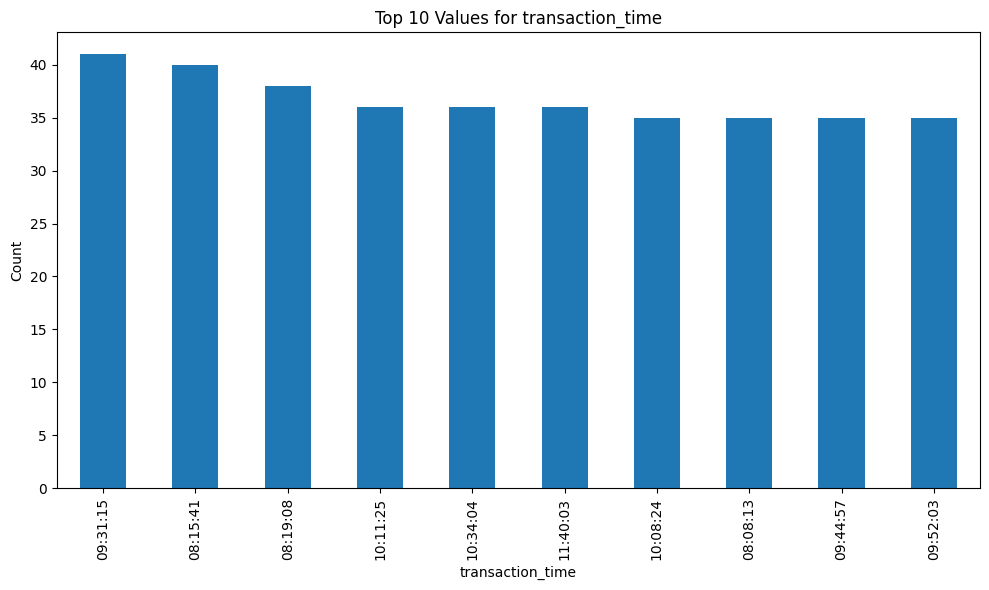


Distribution of store_location:
store_location
Hell's Kitchen     50735
Astoria            50599
Lower Manhattan    47782
Name: count, dtype: int64
Total unique values: 3
Most common value: 'Hell's Kitchen' (34.02% of records)


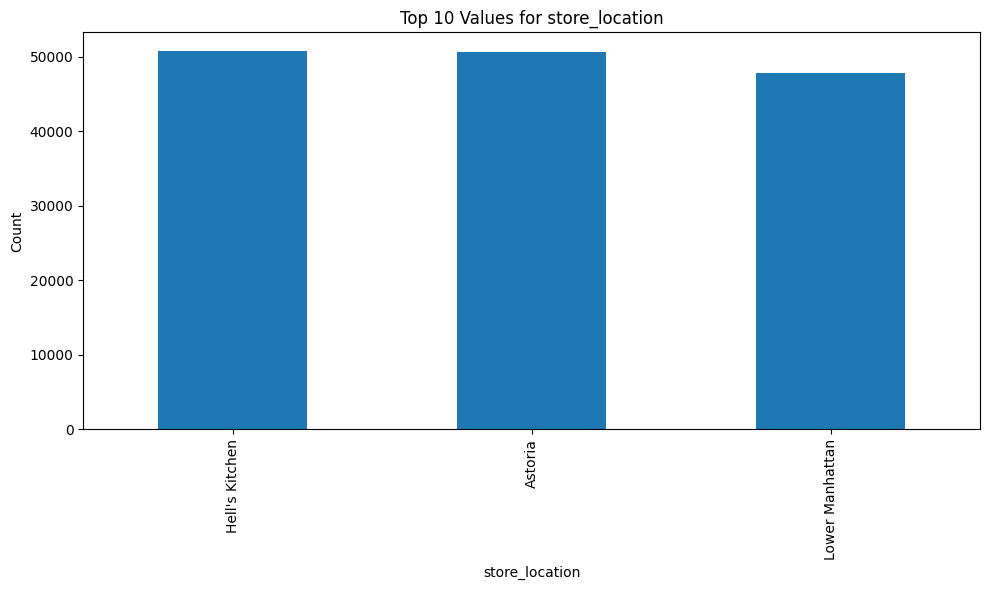


Distribution of product_category:
product_category
Coffee                58416
Tea                   45449
Bakery                22796
Drinking Chocolate    11468
Flavours               6790
Coffee beans           1753
Loose Tea              1210
Branded                 747
Packaged Chocolate      487
Name: count, dtype: int64
Total unique values: 9
Most common value: 'Coffee' (39.17% of records)


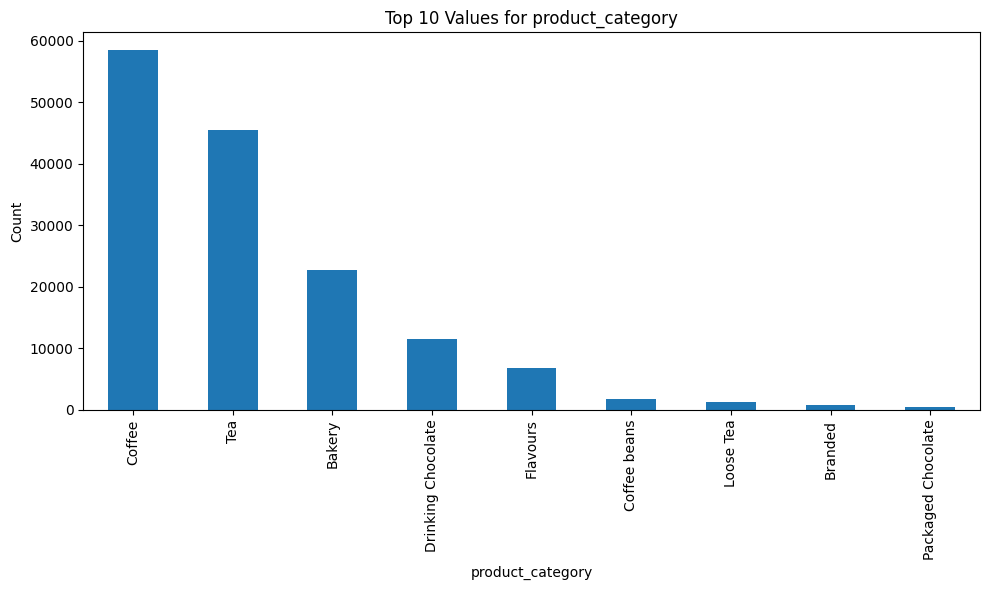


Distribution of product_type:
product_type
Brewed Chai tea          17183
Gourmet brewed coffee    16912
Barista Espresso         16403
Hot chocolate            11468
Brewed Black tea         11350
Brewed herbal tea        11245
Scone                    10173
Organic brewed coffee     8489
Drip coffee               8477
Premium brewed coffee     8135
Name: count, dtype: int64
Total unique values: 29
Most common value: 'Brewed Chai tea' (11.52% of records)


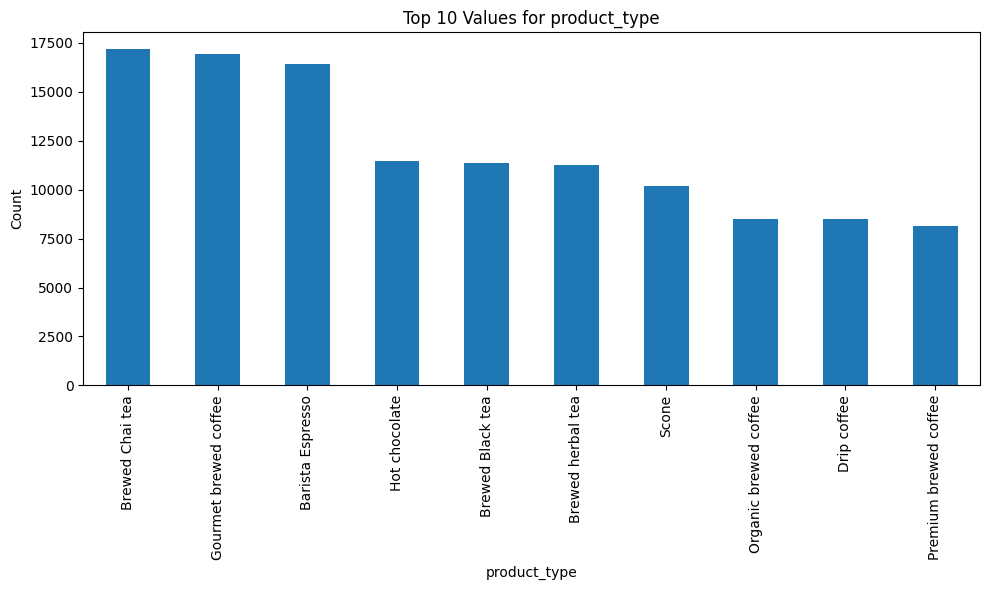


Distribution of product_detail:
product_detail
Chocolate Croissant             3076
Earl Grey Rg                    3053
Dark chocolate Lg               3029
Morning Sunrise Chai Rg         3026
Columbian Medium Roast Rg       3013
Latte                           2990
Sustainably Grown Organic Lg    2961
Traditional Blend Chai Rg       2955
Spicy Eye Opener Chai Lg        2951
Peppermint Rg                   2949
Name: count, dtype: int64
Total unique values: 80
Most common value: 'Chocolate Croissant' (2.06% of records)


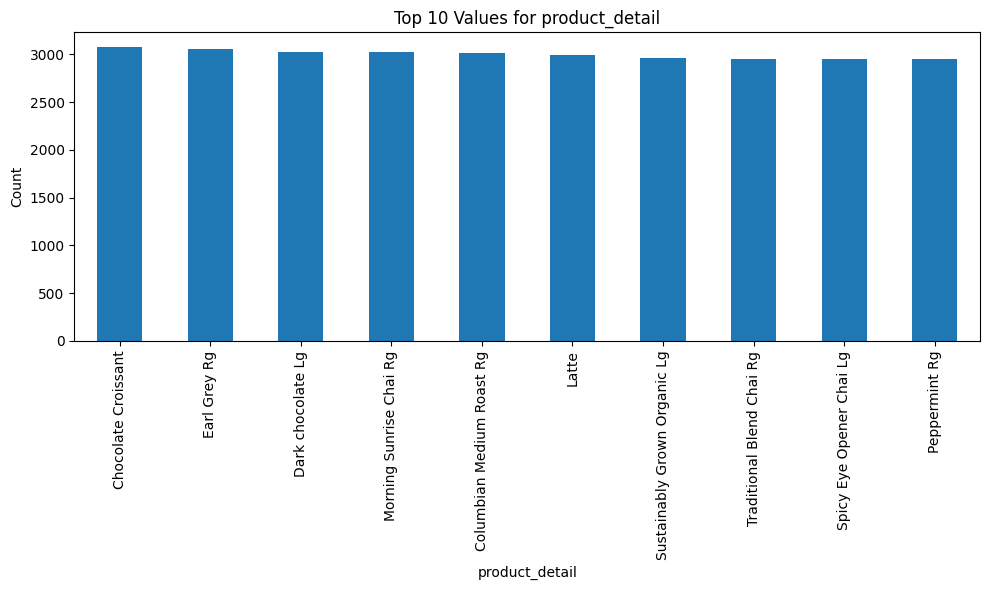


Detailed Product Category Analysis:

Product Category to Product Type Relationship:
product_type        Barista Espresso  Biscotti  Black tea  Brewed Black tea  \
product_category                                                              
Bakery                           0.0    5711.0        0.0               0.0   
Branded                          0.0       0.0        0.0               0.0   
Coffee                       16403.0       0.0        0.0               0.0   
Coffee beans                     0.0       0.0        0.0               0.0   
Drinking Chocolate               0.0       0.0        0.0               0.0   
Flavours                         0.0       0.0        0.0               0.0   
Loose Tea                        0.0       0.0      303.0               0.0   
Packaged Chocolate               0.0       0.0        0.0               0.0   
Tea                              0.0       0.0        0.0           11350.0   

product_type        Brewed Chai tea  Brewed G

<Figure size 1200x800 with 0 Axes>

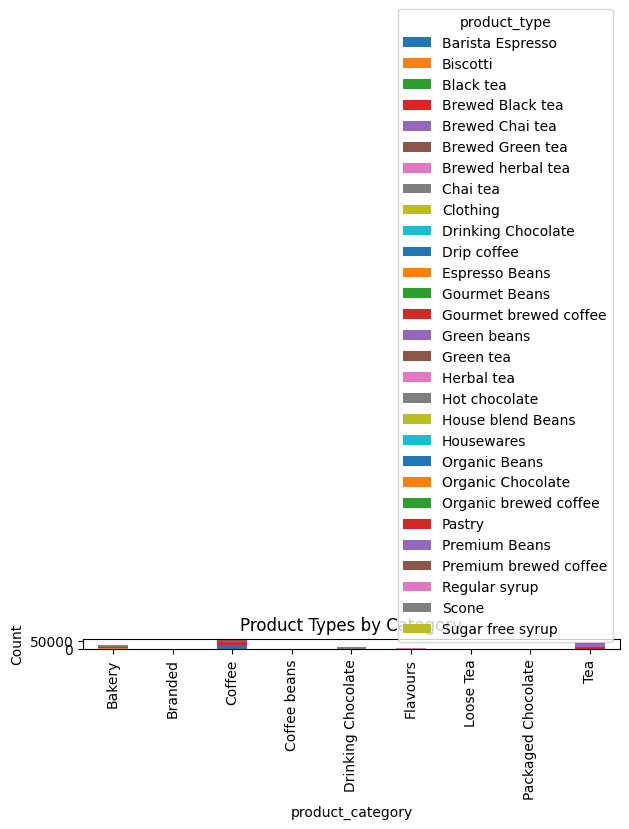


--- DATA QUALITY ASSESSMENT SUMMARY ---

Dataset Size: 149116 rows, 11 columns

Completeness: No missing values detected

Accuracy Issues: 1 types of issues detected

Consistency Issues: 1 types of issues detected

Label Distribution: Analyzed 5 categorical columns

Overall Data Quality Score: 93.94%


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,9340,2023-01-17,09:05:20,8,8,Hell's Kitchen,8,45.0,Coffee beans,Premium Beans,Civet Cat
1,9395,2023-01-17,09:55:47,8,8,Hell's Kitchen,8,45.0,Coffee beans,Premium Beans,Civet Cat
2,68976,2023-04-17,09:55:47,8,8,Hell's Kitchen,8,45.0,Coffee beans,Premium Beans,Civet Cat
3,69151,2023-04-17,11:18:31,8,8,Hell's Kitchen,8,45.0,Coffee beans,Premium Beans,Civet Cat
4,98233,2023-05-17,09:05:20,8,8,Hell's Kitchen,8,45.0,Coffee beans,Premium Beans,Civet Cat
...,...,...,...,...,...,...,...,...,...,...,...
149111,149167,2023-06-30,13:58:11,1,3,Astoria,64,0.8,Flavours,Regular syrup,Hazelnut syrup
149112,149250,2023-06-30,15:35:22,1,8,Hell's Kitchen,65,0.8,Flavours,Sugar free syrup,Sugar Free Vanilla syrup
149113,149281,2023-06-30,16:20:44,1,5,Lower Manhattan,64,0.8,Flavours,Regular syrup,Hazelnut syrup
149114,149335,2023-06-30,17:33:45,1,8,Hell's Kitchen,63,0.8,Flavours,Regular syrup,Carmel syrup


In [10]:
assess_data_quality('Coffee Shop Sales.xlsx')